In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from scipy import sparse
import pandas as pd

try:
    import scienceplots
except ModuleNotFoundError:
    pass
import plotly.graph_objects as go
plt.style.use(["science", "notebook", "grid", "dark_background"])

In [7]:
class SigMoidOptimiser:
    def __init__(self, xtrue, ytrue) -> None:
        self.xtrue = xtrue
        self.w, self.b = np.random.uniform(-6, 6,  size=2)
        self.ytrue = ytrue
        self.yhat = self.calc_sigmoid(self.xtrue, self.w, self.b)
    
    @staticmethod
    def calc_sigmoid(x, w, b):
        return 1.0 / (1.0 + np.exp(-(w * x + b)))

    def loss(self, w, b):
        preds = self.calc_sigmoid(self.xtrue, w, b)
        return 0.5 * np.sum((preds - self.ytrue) ** 2)
    
    
    def grad_w(self, w, b, x, y):
        fx = self.calc_sigmoid(x, w, b)
        return (fx - y) * fx * (1 - fx) * x
    
    def grad_b(self, w, b, x, y):
        fx = self.calc_sigmoid(x, w, b)
        return (fx - y) * fx * (1 - fx)

    @staticmethod
    def calculate_lookahead_gradient(x, ytrue, w, b, v_w, v_b, lr, gamma):
        w_lookahead = w - gamma * v_w
        b_lookahead = b - gamma * v_b
        yhat = SigMoidOptimiser.calc_sigmoid(x, w_lookahead, b_lookahead)
        dw_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat) * x)
        db_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat))
        return dw_lookahead, db_lookahead

    def do_vanilla_gradient_descent(self, lr=0.02, epochs=100, starting_point = (-4, -4)):
        """Does vanilla gradient descent
        Args:
            lr (float, optional): Learning rate. Defaults to 0.02.
            epochs (int, optional): Number of epochs. Defaults to 100.
            starting_point (tuple, optional): (w0, b0) Starting point for the optimisation. 
                                                Defaults to (-4, -4).
        Returns:
            np.array: Losses through the epochs
            np.array: ws through the epochs
            np.array: bs through the epochs"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        for idx in range(epochs):
            dw, db = 0.0, 0.0
            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)
            self.w -= lr * dw # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= lr * db # Update the b value
            bs[idx] = self.b # Append the new b value
            self.losses[idx] = self.loss(self.w, self.b) # Calculate the new loss
        return self.losses, ws, bs
    
    def do_stochastic_vanilla_gradient_descent(self, lr=0.02, epochs=100, starting_point = (-2, -2.5)):
        """Does stochastic vanilla gradient descent

        Args:
            lr (float, optional): Learning rate. Defaults to 0.02.
            epochs (int, optional): Number of epochs. Defaults to 100.
            starting_point (tuple, optional): (w0, b0) Starting point for the optimisation. 
                                                Defaults to (-4, -4).
        Returns:
            np.array: Losses through the epochs
            np.array: ws through the epochs
            np.array: bs through the epochs"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = [], []
        for idx in range(epochs):
            dw, db = 0.0, 0.0
            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)
                self.w -= lr * dw # Update the w value
                self.b -= lr * db # Update the b value
                ws.append(self.w) # Append the new w value
                bs.append(self.b) # Append the new b value
            self.losses[idx] = self.loss(self.w, self.b) # Calculate the new loss
        return self.losses, np.array(ws), np.array(bs)
    
    def do_minibatch_gradient_descent(self, lr=0.02, epochs=100, starting_point = (-2, -2.5)):
        """Does minibatch gradient descent
        
        Args:
            lr (float, optional): Learning rate. Defaults to 0.02.
            epochs (int, optional): Number of epochs. Defaults to 100.
            starting_point (tuple, optional): (w0, b0) Starting point for the optimisation. 
                                                Defaults to (-4, -4).
        Returns:
            np.array: Losses through the epochs
            np.array: ws through the epochs
            np.array: bs through the epochs"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = [], []
        for idx in range(epochs):
            dw, db = 0.0, 0.0
            num_pts_seem = 0
            k_batches = 2
            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)

                num_pts_seem += 1

                if num_pts_seem % k_batches == 0:
                    self.w -= lr * dw # Update the w value
                    self.b -= lr * db # Update the b value
                    ws.append(self.w) # Append the new w value
                    bs.append(self.b) # Append the new b value

            self.losses[idx] = self.loss(self.w, self.b) # Calculate the new loss
        return self.losses, np.array(ws), np.array(bs)
    
    def do_momentum_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0. # Initialising the velocity
        
        for idx in range(epochs):
            dw, db = 0.0, 0.0

            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)

            # Look at the history of the gradients
            v_w = gamma * v_w + lr * dw
            v_b = gamma * b_w + lr * db

            self.w -= v_w # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= v_b # Update the b value
            bs[idx] = self.b # Append the new b value

            # Calculate the new predictions and loss
            self.losses[idx] = self.loss(self.w, self.b) # Calculate the new loss
        return self.losses, ws, bs
    
    def do_nesterov_accelerated_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does nested momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.

        for idx in range(epochs):
            dw_lookahead, db_lookahead = self.calculate_lookahead_gradient(self.xtrue, self.ytrue, self.w, self.b, v_w, b_w, lr, gamma)

            v_w = gamma * v_w + lr * dw_lookahead
            v_b = gamma * b_w + lr * db_lookahead

            self.w -= v_w
            ws[idx] = self.w

            self.b -= v_b
            bs[idx] = self.b

            self.losses[idx] = self.loss(self.w, self.b)
        return self.losses, ws, bs
    
    def do_adagrad(self, lr = 0.02, epochs = 100, eps = 1e-7, starting_point = (-4, -4)):
        """Does ADA Grad gradient descent"""

        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.

        for idx in range(epochs):
            db, dw = 0., 0.

            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)

            v_w = v_w + dw ** 2
            v_b = b_w + db ** 2

            self.w -= lr * dw / (np.sqrt(v_w) + eps) # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= lr * db / (np.sqrt(v_b) + eps) # Update the b value
            bs[idx] = self.b # Append the new b value

            self.losses[idx] = self.loss(self.w, self.b)
        return self.losses, ws, bs
    
    def do_rmsprop(self, lr = 0.02, epochs = 100, eps = 1e-7, beta = 0.95, starting_point = (-4, -4)):
        """Does RMS prop gradient descent"""

        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.

        for idx in range(epochs):
            db, dw = 0., 0.

            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)

            v_w = beta * v_w + (1 - beta) * dw ** 2
            v_b = beta * b_w + (1 - beta) * db ** 2

            self.w -= lr * dw / (np.sqrt(v_w) + eps) # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= lr * db / (np.sqrt(v_b) + eps) # Update the b value
            bs[idx] = self.b # Append the new b value

            self.losses[idx] = self.loss(self.w, self.b)
        return self.losses, ws, bs
    

    def do_adam(self, lr = 0.02, epochs = 100, eps = 1e-8, beta1 = 0.9, beta2 = 0.999, starting_point = (-4, -4)):
        """Does Adam gradient descent"""

        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.
        m_w, m_b = 0., 0.
        t = 0

        for idx in range(epochs):
            db, dw = 0., 0.

            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)

            t += 1
            m_w = beta1 * m_w + (1 - beta1) * dw
            m_b = beta1 * m_b + (1 - beta1) * db
            v_w = beta2 * v_w + (1 - beta2) * dw ** 2
            v_b = beta2 * b_w + (1 - beta2) * db ** 2

            m_w_hat = m_w / (1 - beta1 ** t)
            m_b_hat = m_b / (1 - beta1 ** t)
            v_w_hat = v_w / (1 - beta2 ** t)
            v_b_hat = v_b / (1 - beta2 ** t)

            self.w -= lr * m_w_hat / (np.sqrt(v_w_hat) + eps)
            ws[idx] = self.w
            self.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + eps)
            bs[idx] = self.b

            self.losses[idx] = self.loss(self.w, self.b)

        return self.losses, ws, bs

    def trace_path(self, xtrue, y_pts, color, label, ax, markersize = 1):
        ax.plot(xtrue, y_pts, "o--", color=color, label = label, linewidth = 0.5, markersize = markersize)
        ax.scatter(xtrue[0], y_pts[0], color = color, s = 200, marker = "p")
        ax.scatter(xtrue[-1], y_pts[-1], color = color, s = 200, marker = "x")
        ax.legend()

    def plot_loss_landscape(self, fig, ax, cmap="coolwarm"):
        w_values = np.linspace(-4, 4, 200)  # Example range for w
        b_values = np.linspace(-4, 4, 200)  # Example range for b
        W, B = np.meshgrid(w_values, b_values)

        # Calculate predictions and MSE loss for each w, b pair
        loss_matrix = np.zeros(W.shape)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j]
                b = B[i, j]
                mse_loss = self.loss(w, b)  # Calculate MSE loss for this w, b
                loss_matrix[i, j] = mse_loss

        cax = ax.contourf(W, B, loss_matrix, levels=20, cmap=cmap)
        ax.set_xlabel(r"w $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_ylabel(r"b $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_title("Loss landscape", fontsize = 20, fontweight = "bold")
        fig.colorbar(cax, ax=ax, orientation="vertical", label = "Loss")
        return loss_matrix, w_values, b_values

In [8]:
# Matrix dimensions
rows = 100
# Sparsity level: 10% non-zero
density = 0.2

# Generate a random sparse matrix
# Here, we use a uniform distribution for the non-zero elements
sparse_matrix = sparse.random(rows, 1, density=density, data_rvs=stats.uniform(loc=-1, scale=2).rvs)

# Convert to a dense format for visualization or further processing
xtrue = sparse_matrix.toarray().ravel()
ytrue = 1 / (1 + np.exp(-xtrue)) + np.random.normal(0, 0.1, size = xtrue.shape)

In [9]:
# xtrue = np.array([0.5       ,  0.57575758, 0.6010101 ,
#        2.8989899 , 2.92424242, 2.94949495, 2.97474747, 3.        ])

# ytrue = np.array([0.20000002, 0.2226041 , 0.23053222,
#        0.94844224, 0.95061041, 0.95269195, 0.95468994, 0.95660739])

sig = SigMoidOptimiser(xtrue, ytrue)

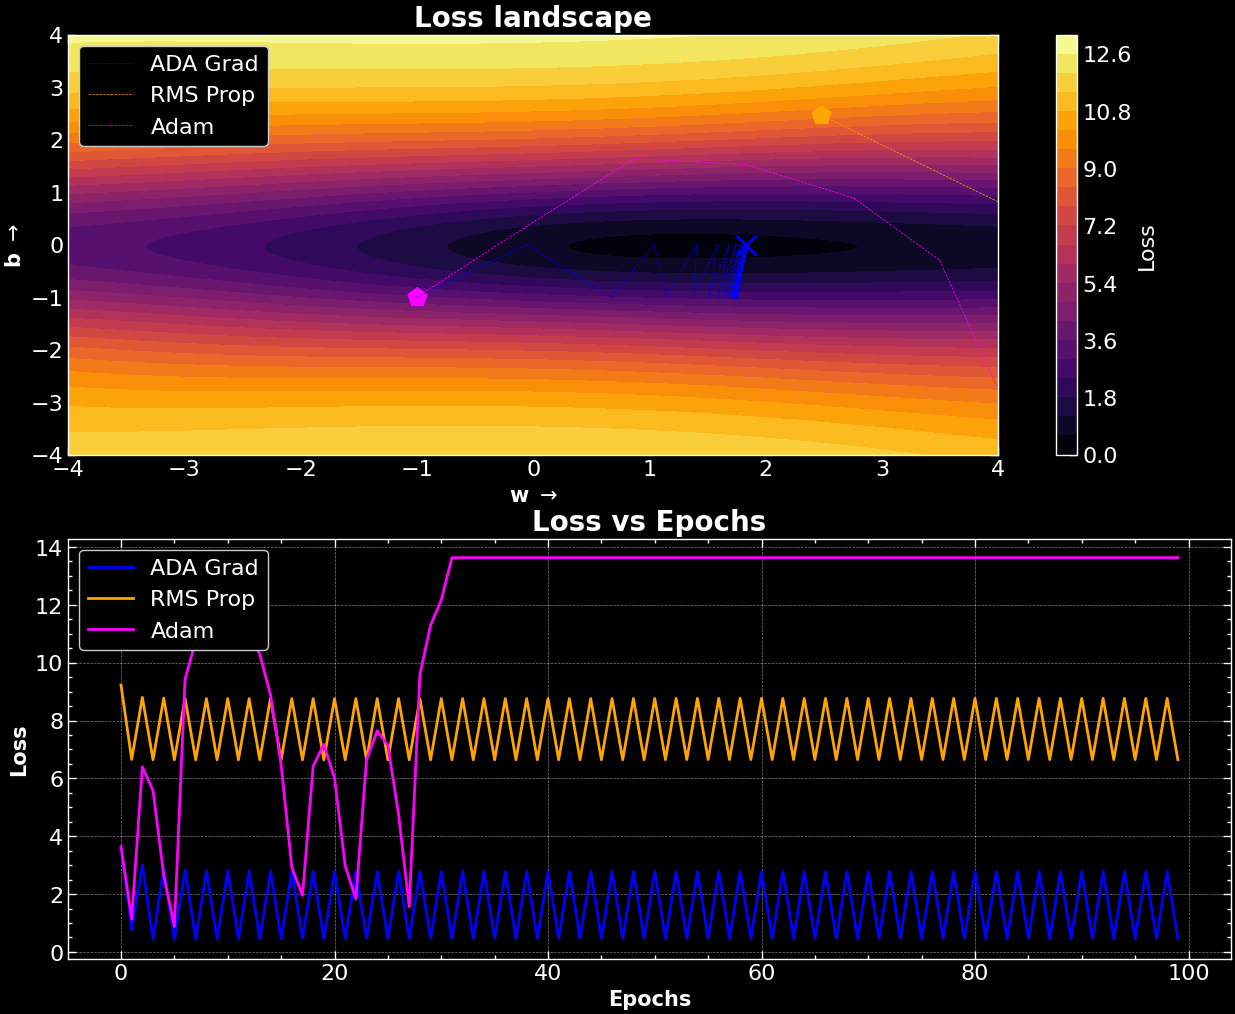

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
ax1, ax2 = ax.ravel()
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

EPOCHS = 100
loss_matrix, w_vals, b_vals = sig.plot_loss_landscape(fig, ax1, cmap = "inferno")
# losses_VGD, ws_VGD, bs_VGD = sig.do_vanilla_gradient_descent(lr = 1.0, epochs = EPOCHS, starting_point=(-2, -2))
# losses_MGD, ws_MGD, bs_MGD = sig.do_momentum_gradient_descent(lr = 1.0, epochs = EPOCHS, gamma = 0.9, starting_point=(-2, -2))
# losses_NMGD, ws_NMGD, bs_NMGD = sig.do_nesterov_accelerated_gradient_descent(lr = 1.0, epochs = EPOCHS, gamma = 0.9, starting_point=(-2, -2))
# losses_SGD, ws_SGD, bs_SGD = sig.do_stochastic_vanilla_gradient_descent(lr=1.0, epochs=EPOCHS, starting_point=(-2, -2))
# losses_mini, ws_mini, bs_mini = sig.do_minibatch_gradient_descent(lr=1.0, epochs=EPOCHS, starting_point=(-2, -2))
losses_ada, ws_ada, bs_ada = sig.do_adagrad(lr=1.0, epochs=EPOCHS, starting_point=(-2, -2))
losses_rms, ws_rms, bs_rms = sig.do_rmsprop(lr=1.0, epochs=EPOCHS, beta = 0.95, starting_point=(-2, -2))
losses_adam, ws_adam, bs_adam = sig.do_adam(lr=1.0, epochs=EPOCHS, starting_point=(-2, -2))


# sig.trace_path(ws_VGD, bs_VGD, "white", "Vanilla Gradient Descent", ax1)
# sig.trace_path(ws_MGD, bs_MGD, "red", "Momentum Gradient Descent", ax1)
# sig.trace_path(ws_NMGD, bs_NMGD, "lightgreen", "NAG", ax1)
# sig.trace_path(ws_SGD, bs_SGD, "gold", "Stochastic Gradient Descent", ax1, markersize=0.2)
# sig.trace_path(ws_mini, bs_mini, "cyan", "Minibatch Gradient Descent", ax1, markersize=0.2)
sig.trace_path(ws_ada, bs_ada, "blue", "ADA Grad", ax1, markersize=0.2)
sig.trace_path(ws_rms, bs_rms, "orange", "RMS Prop", ax1, markersize=0.2)
sig.trace_path(ws_adam, bs_adam, "magenta", "Adam", ax1, markersize=0.2)


# ax2.plot(losses_VGD, label = "Vanilla Gradient Descent", color = "white")
# ax2.plot(losses_MGD, label = "Momentum Gradient Descent", color = "red")
# ax2.plot(losses_NMGD, label = "NAG", color = "lightgreen")
# ax2.plot(losses_SGD, label = "SGD", color = "gold")
# ax2.plot(losses_mini, label = "Minibatch Gradient Descent", color = "cyan")
ax2.plot(losses_ada, label = "ADA Grad", color = "blue")
ax2.plot(losses_rms, label = "RMS Prop", color = "orange")
ax2.plot(losses_adam, label = "Adam", color = "magenta")

ax2.set_xlabel("Epochs", fontsize = 15, fontweight = "bold")
ax2.set_ylabel("Loss", fontsize = 15, fontweight = "bold")
ax2.set_title("Loss vs Epochs", fontsize = 20, fontweight = "bold")
ax2.legend()

/var/folders/hd/lczmblb56dz80y7bzzcrq8m80000gn/T/ipykernel_14123/3806658433.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(w * x + b)))
MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/hd/lczmblb56dz80y7bzzcrq8m80000gn/T/ipykernel_14123/3591453786.py:142: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point_ada.set_data(ws_ada[frame_end], bs_ada[frame_end]) # ADA Grad
/var/folders/hd/lczmblb56dz80y7bzzcrq8m80000gn/T/ipykernel_14123/3591453786.py:143: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point_rms.set_data(ws_rms[frame_end], bs_rms[frame_end]) # RMS Prop
/var/folders/hd/lczmblb56dz80y7bzzcrq8m80000gn/T/ipykernel_14123/3591453786.py:144: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be re

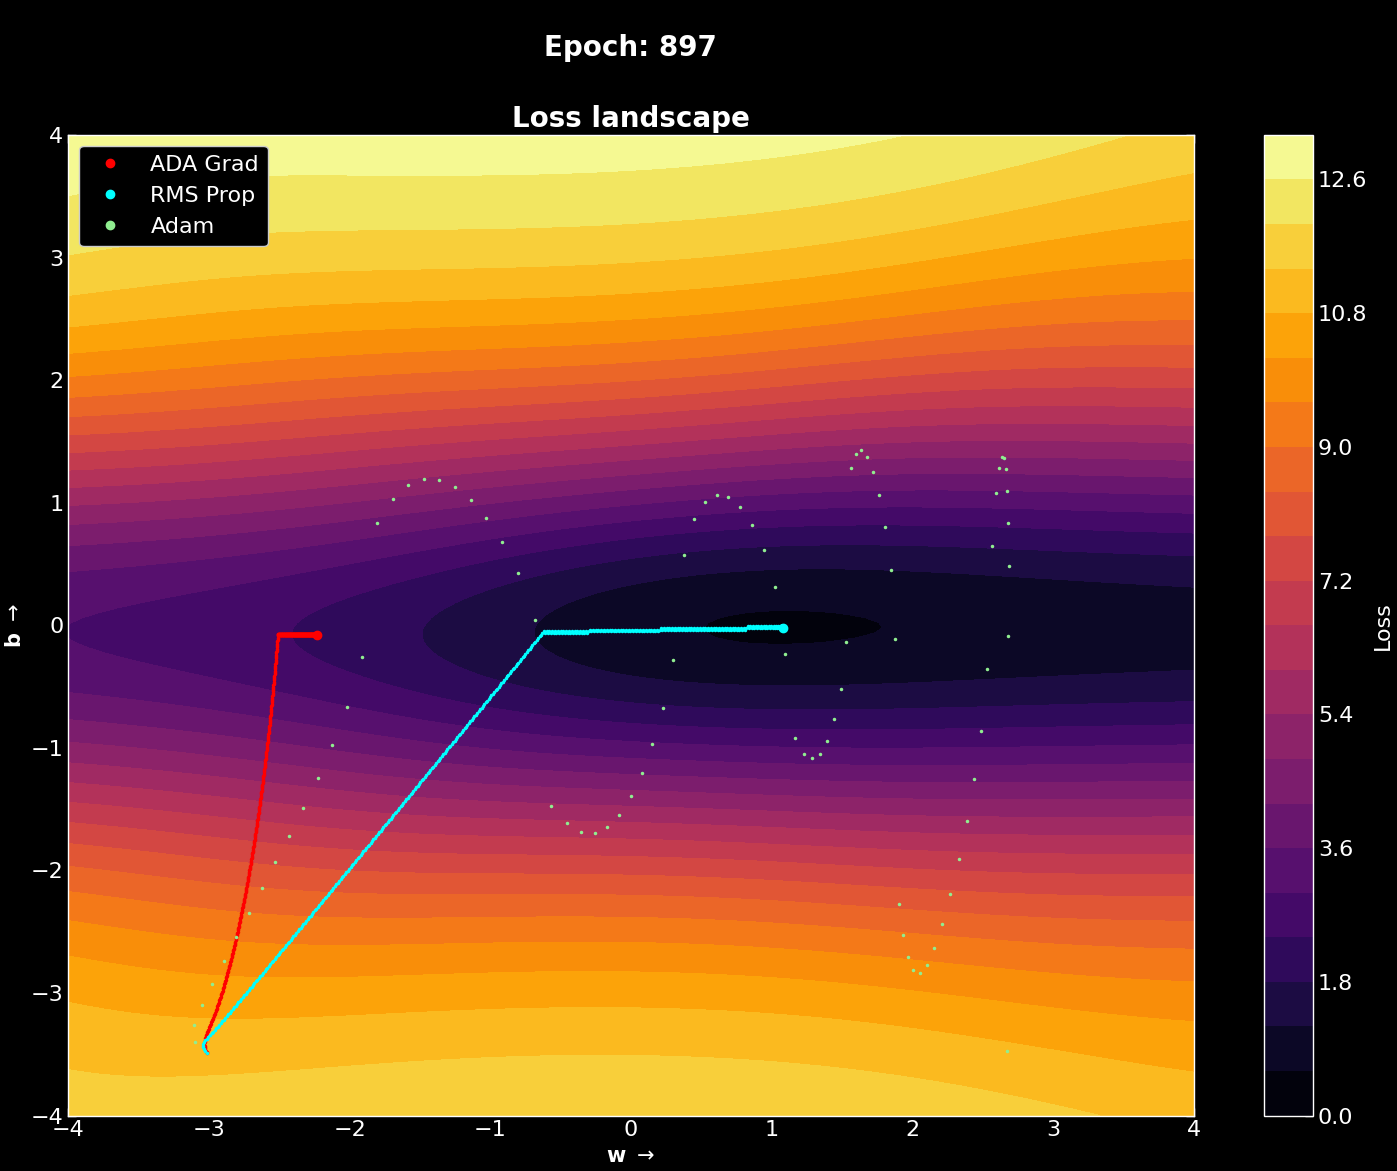

In [17]:
fig, ax1 = plt.subplots(1, figsize=(15, 12))

loss_matrix, w_vals, b_vals = sig.plot_loss_landscape(fig, ax1, cmap = "inferno")

# ax1.set_xlim(-2.5, 2.5)
# ax1.set_ylim(-3, 1)
EPOCHS = 1000
STARTING_POINT = (-3, -3.5)
# losses_VGD, ws_VGD, bs_VGD = sig.do_vanilla_gradient_descent(lr = 0.1, epochs = EPOCHS, starting_point=STARTING_POINT)
# losses_MGD, ws_MGD, bs_MGD = sig.do_momentum_gradient_descent(lr = 0.1, epochs = EPOCHS, gamma = 0.9, starting_point=STARTING_POINT)
# losses_NMGD, ws_NMGD, bs_NMGD = sig.do_nesterov_accelerated_gradient_descent(lr = 0.1, epochs = EPOCHS, gamma = 0.9, starting_point=STARTING_POINT)
# losses_SGD, ws_SGD, bs_SGD = sig.do_stochastic_vanilla_gradient_descent(lr=1.0, epochs=EPOCHS, starting_point=STARTING_POINT)
# losses_mini, ws_mini, bs_mini = sig.do_minibatch_gradient_descent(lr=1.0, epochs=EPOCHS, starting_point=STARTING_POINT) # Minibatch
losses_ada, ws_ada, bs_ada = sig.do_adagrad(lr=0.01, epochs=EPOCHS, starting_point=STARTING_POINT)
losses_rms, ws_rms, bs_rms = sig.do_rmsprop(lr=0.01, epochs=EPOCHS, beta = 0.5, starting_point=STARTING_POINT)
losses_adam, ws_adam, bs_adam = sig.do_adam(lr=0.1, epochs=EPOCHS, starting_point=STARTING_POINT)


# line_pt_vgd, = ax1.plot([], [], "o", color = "lightgreen", markersize = 1.5) # VGD
# line_pt_mgd, = ax1.plot([], [], "ro", markersize = 1.5) # MGD
# line_pt_nag, = ax1.plot([], [], "o", color = "cyan", markersize = 1.5) # NAG
# line_pt_sgd, = ax1.plot([], [], "-", linewidth = 1.0, color = "gold", markersize = 1.2) # NAG
# line_pt_mini, = ax1.plot([], [], "-", linewidth = 1.0, color = "cyan", markersize = 1.2) # Minibatch
line_pt_ada, = ax1.plot([], [], "o", color = "red", markersize = 1.5) # ADA Grad
line_pt_rms, = ax1.plot([], [], "o", color = "cyan", markersize = 1.5) # RMS Prop
line_pt_adam, = ax1.plot([], [], "o", color = "lightgreen", markersize = 1.5) # Adam



# line_sig_vgd, = ax2.plot([], [], "-", color = "lightgreen", markersize = 0.2,  label = f"w(VGD) = {ws_VGD[0]:.2f}, b(VGD) = {bs_VGD[0]:.2f}") #VGD
# line_sig_mgd, = ax2.plot([], [], "r-", markersize = 0.2,  label = f"w(MGD)= {ws_MGD[0]:.2f}, b(MGD) = {bs_MGD[0]:.2f}") #MGD
# line_sig_nag, = ax2.plot([], [], "-", color = "cyan", markersize = 0.2,  label = f"w(NAG) = {ws_NMGD[0]:.2f}, b(NAG) = {bs_NMGD[0]:.2f}") #NAG
# line_sig_sgd, = ax2.plot([], [], "-", color = "gold", markersize = 0.2,  
                        #  label = f"w(SGD) = {ws_SGD[0]:.2f}, b(SGD) = {bs_SGD[0]:.2f}") #SGD
# line_sig_mini, = ax2.plot([], [], "-", color = "cyan", markersize = 0.2,
                            # label = f"w(Mini) = {ws_mini[0]:.2f}, b(Mini) = {bs_mini[0]:.2f}") # Minibatch
# line_sig_ada, = ax2.plot([], [], "-", color = "red", markersize = 0.2,
#                             label = f"w(ADA) = {ws_ada[0]:.2f}, b(ADA) = {bs_ada[0]:.2f}") # ADA Grad
# line_sig_rms, = ax2.plot([], [], "-", color = "cyan", markersize = 0.2,
#                             label = f"w(RMS) = {ws_rms[0]:.2f}, b(RMS) = {bs_rms[0]:.2f}") # RMS Prop
# line_sig_adam, = ax2.plot([], [], "-", color = "lightgreen", markersize = 0.2,
#                             label = f"w(Adam) = {ws_adam[0]:.2f}, b(Adam) = {bs_adam[0]:.2f}") # Adam

# point_vgd, = ax1.plot([], [], "o", color = "lightgreen",  label = "Vanilla Gradient Descent") #VGD
# point_mgd, = ax1.plot([], [], "ro",  label = "Momentum based Gradient Descent") #MGD
# point_nag, = ax1.plot([], [], "o", color = "cyan",  label = "NAG") #NAG
# point_sgd, = ax1.plot([], [], "o", color = "gold",  label = "SGD") #SGD
# point_mini, = ax1.plot([], [], "o", color = "cyan",  label = "Minibatch") # Minibatch
point_ada, = ax1.plot([], [], "o", color = "red",  label = "ADA Grad") # ADA Grad
point_rms, = ax1.plot([], [], "o", color = "cyan",  label = "RMS Prop") # RMS Prop
point_adam, = ax1.plot([], [], "o", color = "lightgreen",  label = "Adam") # Adam

ax1.legend(loc = "upper left")

desired_frames = 300
skip_rate = len(ws_rms) // desired_frames

suptitle = fig.suptitle('Epoch: 0', fontsize = 20, fontweight = "bold")

def init():
    # line_pt_vgd.set_data([], [])
    # line_pt_mgd.set_data([], [])
    # line_pt_nag.set_data([], [])
    # line_pt_sgd.set_data([], [])
    # line_pt_mini.set_data([], [])
    line_pt_ada.set_data([], [])
    line_pt_rms.set_data([], [])
    line_pt_adam.set_data([], [])


    # line_sig_vgd.set_data([], [])
    # line_sig_mgd.set_data([], [])
    # line_sig_nag.set_data([], [])
    # line_sig_sgd.set_data([], [])
    # line_sig_mini.set_data([], [])
    # line_sig_ada.set_data([], [])
    # line_sig_rms.set_data([], [])
    # line_sig_adam.set_data([], [])

    # point_vgd.set_data([], [])
    # point_mgd.set_data([], [])
    # point_nag.set_data([], [])
    # point_sgd.set_data([], [])
    # point_mini.set_data([], [])
    point_ada.set_data([], [])
    point_rms.set_data([], [])
    point_adam.set_data([], [])


    suptitle.set_text("Epoch: 0")
    return  line_pt_ada, line_pt_rms, point_ada, point_rms, line_pt_adam,  point_adam, suptitle

xfit = np.linspace(0, 3, 100)
epoch_text = ax1.text(0.5, 1.08, "Epoch: 0", fontsize=20, fontweight="bold", ha="center", transform=ax1.transAxes)

def animate(i):
    frame_end = skip_rate * i

    # w_vgd, b_vgd = ws_VGD[frame_end], bs_VGD[frame_end] # VGD
    # w_mgd, b_mgd = ws_MGD[frame_end], bs_MGD[frame_end] # MGD
    # w_nag, b_nag = ws_NMGD[frame_end], bs_NMGD[frame_end] # NAG
    # w_sgd, b_sgd = ws_SGD[frame_end], bs_SGD[frame_end] # SGD
    # w_mini, b_mini = ws_mini[frame_end], bs_mini[frame_end] # Minibatch
    w_ada, b_ada = ws_ada[frame_end], bs_ada[frame_end] # ADA Grad
    w_rms, b_rms = ws_rms[frame_end], bs_rms[frame_end] # RMS Prop
    w_adam, b_adam = ws_adam[frame_end], bs_adam[frame_end] # Adam

    # y_pts_vgd = sig.calc_sigmoid(xfit, w_vgd, b_vgd) # VGD
    # y_pts_mgd = sig.calc_sigmoid(xfit, w_mgd, b_mgd) # MGD
    # y_pts_nag = sig.calc_sigmoid(xfit, w_nag, b_nag) # NAG
    # y_pts_sgd = sig.calc_sigmoid(xfit, w_sgd, b_sgd) #SGD
    # y_pts_mini = sig.calc_sigmoid(xfit, w_mini, b_mini) # Minibatch
    y_pts_ada = sig.calc_sigmoid(xfit, w_ada, b_ada) # ADA Grad
    y_pts_rms = sig.calc_sigmoid(xfit, w_rms, b_rms) # RMS Prop
    y_pts_adam = sig.calc_sigmoid(xfit, w_adam, b_adam) # Adam

    # line_pt_vgd.set_data(ws_VGD[:frame_end], bs_VGD[:frame_end]) # VGD
    # line_pt_mgd.set_data(ws_MGD[:frame_end], bs_MGD[:frame_end]) # MGD
    # line_pt_nag.set_data(ws_NMGD[:frame_end], bs_NMGD[:frame_end]) # NAG
    # line_pt_sgd.set_data(ws_SGD[:frame_end], bs_SGD[:frame_end]) # SGD
    # line_pt_mini.set_data(ws_mini[:frame_end], bs_mini[:frame_end]) # Minibatch
    line_pt_ada.set_data(ws_ada[:frame_end], bs_ada[:frame_end]) # ADA Grad
    line_pt_rms.set_data(ws_rms[:frame_end], bs_rms[:frame_end]) # RMS Prop
    line_pt_adam.set_data(ws_adam[:frame_end], bs_adam[:frame_end]) # Adam


    # line_sig_vgd.set_data(xfit, y_pts_vgd) # VGD
    # line_sig_mgd.set_data(xfit, y_pts_mgd) # MGD
    # line_sig_nag.set_data(xfit, y_pts_nag) # NAG
    # line_sig_sgd.set_data(xfit, y_pts_sgd) # SGD
    # line_sig_mini.set_data(xfit, y_pts_mini) # Minibatch
    # line_sig_ada.set_data(xfit, y_pts_ada) # ADA Grad
    # line_sig_rms.set_data(xfit, y_pts_rms) # RMS Prop
    # line_sig_adam.set_data(xfit, y_pts_adam) # Adam


    # point_vgd.set_data(ws_VGD[frame_end], bs_VGD[frame_end]) # VGD
    # point_mgd.set_data(ws_MGD[frame_end], bs_MGD[frame_end]) # MGD
    # point_nag.set_data(ws_NMGD[frame_end], bs_NMGD[frame_end]) # NAG
    # point_sgd.set_data(ws_SGD[frame_end], bs_SGD[frame_end]) # SGD
    # point_mini.set_data(ws_mini[frame_end], bs_mini[frame_end]) # Minibatch
    point_ada.set_data(ws_ada[frame_end], bs_ada[frame_end]) # ADA Grad
    point_rms.set_data(ws_rms[frame_end], bs_rms[frame_end]) # RMS Prop
    point_adam.set_data(ws_adam[frame_end], bs_adam[frame_end]) # Adam


    epoch_text.set_text(f'Epoch: {frame_end}')


    # ax2.legend(loc = "upper left").texts[0].set_text(f'w(VGD) = {w_vgd:.2f}, b(VGD) = {b_vgd:.2f}')
    # ax2.legend(loc = "upper left").texts[1].set_text(f'w(MGD) = {w_mgd:.2f}, b(MGD) = {b_mgd:.2f}')
    # ax2.legend(loc = "upper left").texts[2].set_text(f'w(NAG) = {w_nag:.2f}, b(NAG) = {b_nag:.2f}')
    # ax2.legend(loc = "upper left").texts[0].set_text(f'w(SGD) = {w_sgd:.2f}, b(SGD) = {b_sgd:.2f}')
    # ax2.legend(loc = "upper left").texts[1].set_text(f'w(Mini) = {w_mini:.2f}, b(Mini) = {b_mini:.2f}')
    # ax2.legend(loc = "upper left").texts[0].set_text(f'w(ADA) = {w_ada:.2f}, b(ADA) = {b_ada:.2f}')
    # ax2.legend(loc = "upper left").texts[1].set_text(f'w(RMS) = {w_rms:.2f}, b(RMS) = {b_rms:.2f}')
    # ax2.legend(loc = "upper left").texts[2].set_text(f'w(Adam) = {w_adam:.2f}, b(Adam) = {b_adam:.2f}')

    return line_pt_ada, line_pt_rms,  point_ada, point_rms, line_pt_adam, point_adam, epoch_text


plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=desired_frames, init_func=init, blit=True)
ani.save("ADAGRAD+RMS+ADAM.gif", writer="imagemagick", fps=30)

In [15]:
# Generate time series data
# Generate increasing time series data
# We can simulate increasing data by adding a trend component to the random data

# Generate a time series data for 365 days starting from Jan 1, 2023
date_range = pd.date_range(start="2023-01-01", periods=100, freq='D')

# Generate random data to simulate a time series (e.g., daily sales data)
np.random.seed(42)  # For reproducibility
data = np.random.randint(100, 500, size=(100,))

# Create a DataFrame to hold the time series data
time_series_data = pd.DataFrame({'Date': date_range, 'Sales': data})




# Define a linearly increasing trend
trend = np.linspace(100, 500, num=100)

# Add the trend to the original random data to simulate increasing sales over time
increasing_data = data + trend

# Update the DataFrame with the increasing time series data
time_series_data['Increasing Sales'] = increasing_data

# Display the first few rows of the updated DataFrame
time_series_data.head()

,Date,Sales,Increasing Sales
0,2023-01-01,202,302.000000
1,2023-01-02,448,552.040404
2,2023-01-03,370,478.080808
3,2023-01-04,206,318.121212
4,2023-01-05,171,287.161616


In [26]:
y = time_series_data["Increasing Sales"]
x = list(range(100))

def calculate_ewm(y, beta):
    # Exponentially moving average
    v_t = np.zeros(y.shape)
    v_t[0] = y[0]

    for t in range(1, y.shape[0]):
        v_t[t] = beta * v_t[t-1] + (1-beta) * y[t]

    return v_t

Text(0.5, 0.98, 'Exponentially Weighted Moving Average')

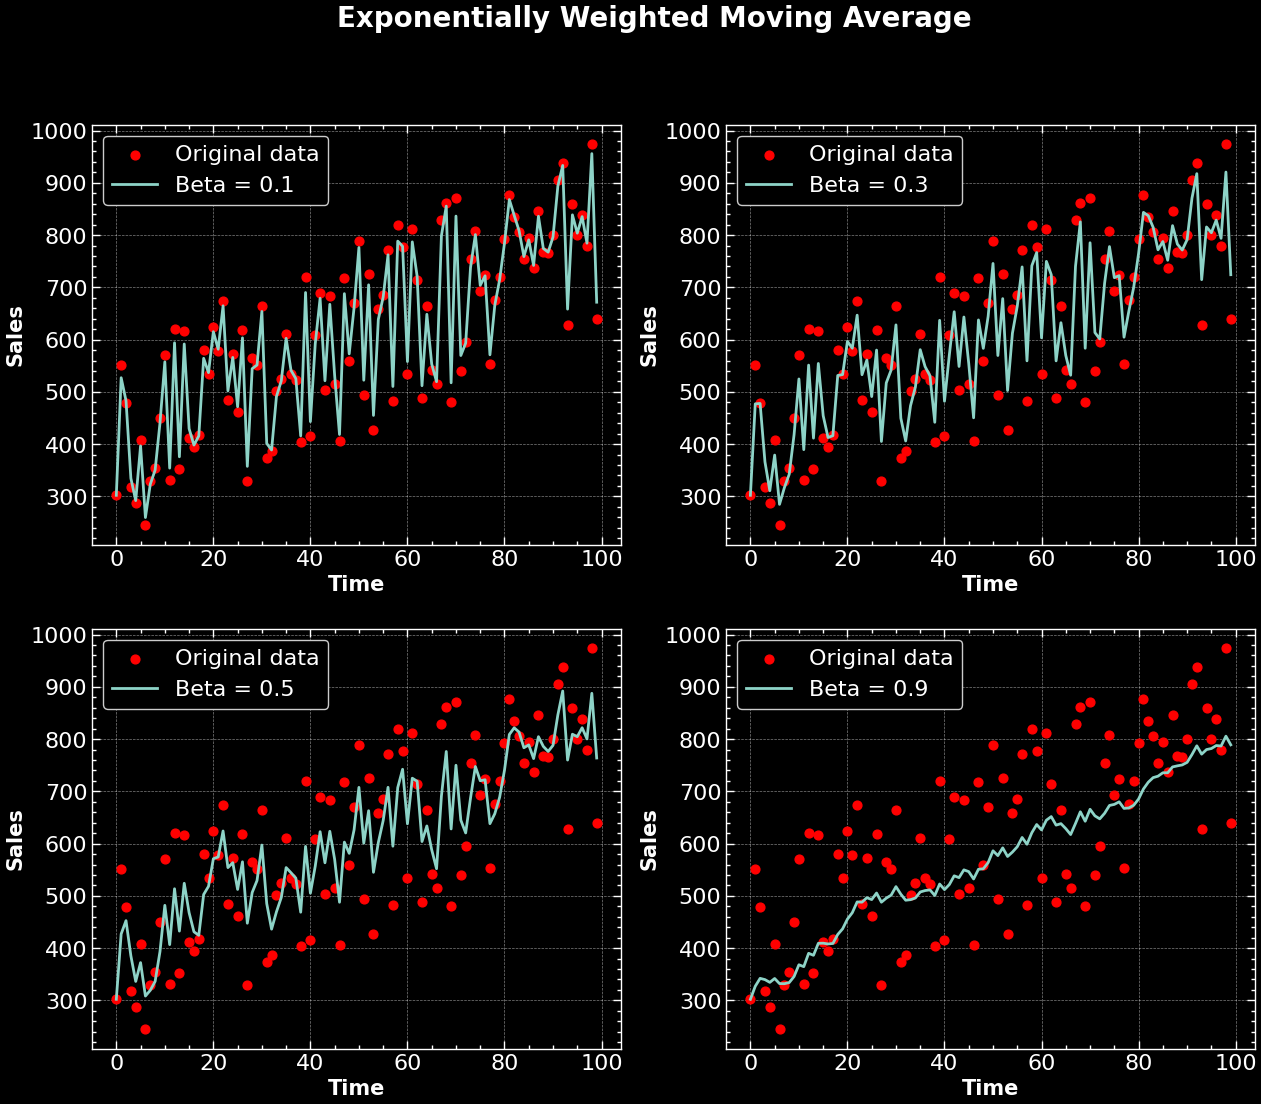

In [31]:
fig, ax = plt.subplots(2, 2, figsize = (15, 12))
ax1, ax2, ax3, ax4 = ax.ravel()

for axi in ax.ravel():
    axi.scatter(x, y, color = "red", s = 40, marker = "o", label = "Original data")

ax1.plot(x, calculate_ewm(y, 0.1), label = "Beta = 0.1")
ax2.plot(x, calculate_ewm(y, 0.3), label = "Beta = 0.3")
ax3.plot(x, calculate_ewm(y, 0.5), label = "Beta = 0.5")
ax4.plot(x, calculate_ewm(y, 0.9), label = "Beta = 0.9")


for axi in ax.ravel():
    axi.set_xlabel("Time", fontsize = 15, fontweight = "bold")
    axi.set_ylabel("Sales", fontsize = 15, fontweight = "bold")
    axi.legend()


plt.suptitle("Exponentially Weighted Moving Average", fontsize = 20, fontweight = "bold")